<h1>Relatório: Aprendizado de máquina e reconhecimento de padrões</h1>
<h3>Aluno: André de Sousa Araújo</h3>
<p>Objetivo principal é estimar a ocorrências de precipações extremas.</p>
<p>Espaço: Região HOUSTON - Texas</p>
<p><b>Base escolhida:</b>
This public dataset was created by the National Oceanic and Atmospheric Administration (NOAA) and includes global data obtained from the USAF Climatology Center.  This dataset covers GSOD data between 1929 and present, collected from over 9000 stations.
</p>
<p>Dataset Source: NOAA</p>

<p>Category: Weather</p>

<p>Use: This dataset is publicly available for anyone to use under the following terms provided by the Dataset Source — http://www.data.gov/privacy-policy#data_policy — and is provided "AS IS" without any warranty, express or implied, from Google. Google disclaims all liability for any damages, direct or indirect, resulting from the use of the dataset.</p>

<p>Update Frequency: daily</p>

<h2 style="color:blue;">Importando o dataset e explorando os dados</h2>

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<p>Fazendo uma consulta básica para listar os campos. Eu defini aliatoriamente apenas para exibir os 10 primeiros registros com chuva acima de 1.0 polegadas sem ordenar. Apenar para ter uma ideia dos dados e atributos. Além disto, usei apenas os dados de 2017.</p>

In [3]:
import datalab.bigquery as bq
import seaborn as sns
import pandas as pd
import numpy as np
import shutil

In [4]:
%sql --module poucos_registros
SELECT ws.name, ws.lat, ws.lon, d.year, d.mo, d.da, d.temp, d.dewp, d.slp, d.stp, d.visib, d.wdsp, d.mxpsd, d.gust, d.prcp, d.flag_prcp, d.fog, d.rain_drizzle
FROM [bigquery-public-data:noaa_gsod.gsod2017] d
  JOIN [bigquery-public-data:noaa_gsod.stations] ws
  ON d.stn = ws.usaf
  and d.wban = ws.wban
where ws.state is not null
and ws.country = 'US'
and d.prcp > 1.0 and d.prcp != 99.99
LIMIT 10

In [5]:
observacoes = bq.Query(poucos_registros).to_dataframe()
observacoes

,ws_name,ws_lat,ws_lon,d_year,d_mo,d_da,d_temp,d_dewp,d_slp,d_stp,d_visib,d_wdsp,d_mxpsd,d_gust,d_prcp,d_flag_prcp,d_fog,d_rain_drizzle
0,EAST MILTON,42.212,-71.114,2017,04,01,17.5,9999.9,1012.3,9999.9,999.9,16.4,21.0,35.9,1.92,G,0,0
1,WATSONVILLE MUNICIPAL ARPT,36.936,-121.789,2017,04,07,54.5,9999.9,1011.6,1006.1,7.8,7.2,18.1,24.1,1.19,G,0,1
2,PEARSON FIELD AIRPORT,45.621,-122.657,2017,02,09,41.8,9999.9,999.1,999.1,6.1,8.4,15.0,21.0,1.29,G,0,1
3,HANCHEY ARMY HELIPORT (FORT R,31.350,-85.667,2017,01,03,65.6,57.6,1001.5,1001.5,8.5,4.3,14.0,22.9,1.50,G,0,1
4,NEW ORLEANS NAS,29.817,-90.017,2017,06,25,81.7,77.8,1019.5,1019.6,7.3,6.4,15.9,25.1,1.25,B,0,1
5,MAYPORT NAF,30.400,-81.417,2017,09,11,78.2,70.1,997.1,994.2,6.4,29.8,59.1,76.0,7.45,G,0,1
6,JACKSONVILLE,34.708,-77.440,2017,09,06,78.4,73.6,1011.5,1010.5,7.4,7.5,15.9,18.1,2.27,G,0,1
7,VICTORIA REGIONAL AIRPORT,28.861,-96.930,2017,08,28,73.9,71.6,1001.1,998.2,5.4,18.3,25.1,36.9,1.96,G,0,1
8,ELK CITY,46.144,-115.596,2017,03,09,32.0,30.4,1023.0,967.4,999.9,0.0,999.9,999.9,2.13,G,0,0
9,EASTERN SLOPES RGNL ARPT,43.991,-70.948,2017,10,30,56.4,51.8,999.0,981.3,7.0,11.7,25.1,36.9,1.06,G,0,1


<p>A precipitação (prcp) <b>precipitação total</b> (chuva e / ou neve derretida) relatada durante o dia em polegadas. Por exemplo na Estação <b>HOOKS MEMORIAL AIRPT </b> choveu 10.42 polegadas quadradadas.

Uma boa prática é entender como está a distribuição dos dados e explorar. As variáveis climáticas de superficie estão relacionadas a determinadas localidades, então não faz sentindo calcular a distribuição para o Pais inteiro, ou para grandes áreas, pelo menos se o objetivo for realizar predições.

Desta forma eu dividi as estações em regiões usando o critério de 10 graus de latitude e longitude.

In [6]:
%sql --module buckets
SELECT ws.name, CONCAT(STRING(INTEGER(ws.lat + 90 * 1000 /100)), '-' ,  STRING (INTEGER(ws.lon + 180 * 1000 /100))) as bucket 
  FROM  [bigquery-public-data:noaa_gsod.stations] ws
 where ws.country = 'US'
 and FLOAT(lat) > -90.0 and FLOAT(lat) < 90.0
 and FLOAT(lon) > -180.0 and FLOAT(lon) < 180.0
order by bucket
LIMIT 10


In [7]:
buckets = bq.Query(buckets).to_dataframe()
buckets

,ws_name,bucket
0,BROOKS BROOK/STP6,839-1666
1,BROOKS BROOK/STP6,839-1666
2,SHAWNEE OKLAHOMA NAS,864-1703
3,SAVANAH GA/HUNTER FLD,867-1718
4,FLORIPA BRAZIL (109),872-1751
5,DATA BUOY 32302,882-1714
6,SERGE-FROLOW (ILE TROMELIN),884-1854
7,ENVIRONM BUOY 32301,890-1695
8,JARVIS ISLAND,899-1639
9,RUSSIAN ICE ISLAND,900-1800


<p>Selecionei a região de Houston no Texas pois teve grandes precipitações relatadas pelos jornais</p>

In [8]:
%sql --module houston
SELECT name, lat, lon,CONCAT(STRING(INTEGER(lat + 90 * 1000 /100)), '-' ,  STRING (INTEGER(lon + 180 * 1000 /100))) as bucket
  FROM  [bigquery-public-data:noaa_gsod.stations] 
 where country = 'US'
 and FLOAT(lat) > -90.0 and FLOAT(lat) < 90.0
 and FLOAT(lon) > -180.0 and FLOAT(lon) < 180.0
 and CONCAT(STRING(INTEGER(lat + 90 * 1000 /100)), '-' ,  STRING (INTEGER(lon + 180 * 1000 /100))) = '929-1704'


In [9]:
regiao_houston = bq.Query(houston).to_dataframe()
regiao_houston

,name,lat,lon,bucket
0,HOUSTON DUNN HELISTOP,29.717,-95.383,929-1704
1,HOUSTON/DUNN HELISTOP,29.717,-95.383,929-1704
2,HUSTON/EXECUTIVE,29.800,-95.900,929-1704
3,HOUSTON EXECUTIVE AIRPORT,29.800,-95.900,929-1704
4,HOUSTON SOUTHWEST AIRPORT,29.506,-95.477,929-1704
5,HOUSTON SOUTHWEST AIRPORT,29.500,-95.477,929-1704
6,PEARLAND RGNL,29.517,-95.250,929-1704
7,CLOVER FIELD AIRPORT,29.519,-95.242,929-1704
8,G BUSH INTERCONTINENTAL AP/HO,29.980,-95.360,929-1704
9,WEST HOUSTON,29.818,-95.673,929-1704


<p> Além de selecionar uma região, o clima também é sazonal. Assim selecionei o mês de Agosto/2017.

In [10]:
%sql --module j_houston
SELECT ws.name,d.da, d.mo, d.year, d.temp, d.dewp, d.slp, d.stp, d.visib, d.wdsp, d.mxpsd, d.gust, d.prcp, d.fog, d.rain_drizzle
, d.snow_ice_pellets, d.hail, d.thunder, d.tornado_funnel_cloud FROM [bigquery-public-data:noaa_gsod.gsod2017] d
  JOIN [bigquery-public-data:noaa_gsod.stations] ws
  ON d.stn = ws.usaf
    and d.wban = ws.wban
  JOIN (SELECT usaf, wban, CONCAT(STRING(INTEGER(lat + 90 * 1000 /100)), '-' ,  STRING (INTEGER(lon + 180 * 1000 /100))) as bucket 
  FROM  [bigquery-public-data:noaa_gsod.stations] 
 where country = 'US'
    and FLOAT(lat) > -90.0 and FLOAT(lat) < 90.0
    and FLOAT(lon) > -180.0 and FLOAT(lon) < 180.0
    and  CONCAT(STRING(INTEGER(lat + 90 * 1000 /100)), '-' ,  STRING (INTEGER(lon + 180 * 1000 /100))) = '929-1704'
order by bucket) b
    on b.usaf = ws.usaf
   and b.wban = ws.wban
where ws.state is not null
and ws.country = 'US'
and INTEGER(d.mo) = 8
order by d.year, d.mo, d.da

In [11]:
ago = bq.Query(j_houston).to_dataframe()
ago[:10]

,ws_name,d_da,d_mo,d_year,d_temp,d_dewp,d_slp,d_stp,d_visib,d_wdsp,d_mxpsd,d_gust,d_prcp,d_fog,d_rain_drizzle,d_snow_ice_pellets,d_hail,d_thunder,d_tornado_funnel_cloud
0,CLOVER FIELD AIRPORT,01,08,2017,85.8,70.6,1015.0,1013.6,9.3,5.4,15.0,19.0,0.00,0,0,0,0,0,0
1,WILLIAM P. HOBBY AIRPORT,01,08,2017,86.6,70.4,1015.1,1013.1,10.0,5.9,13.0,18.1,0.00,0,1,0,0,0,0
2,SUGAR LAND REGIONAL ARPT,01,08,2017,83.0,70.0,1014.7,1011.7,9.9,5.0,12.0,999.9,0.00,0,1,0,0,0,0
3,HOUSTON EXECUTIVE AIRPORT,01,08,2017,81.8,67.4,9999.9,9999.9,9.3,5.7,20.0,27.0,99.99,0,1,0,0,0,0
4,BRAZORIA COUNTY AIRPORT,01,08,2017,81.7,73.7,1014.6,1013.8,9.9,5.1,9.9,999.9,0.00,0,0,0,0,0,0
5,G BUSH INTERCONTINENTAL AP/HO,01,08,2017,82.8,68.8,1014.9,1011.1,10.0,6.1,14.0,18.1,0.00,0,0,0,0,0,0
6,MANCHESTER,01,08,2017,85.8,9999.9,1014.1,9999.9,999.9,4.0,8.9,999.9,0.00,0,0,0,0,0,0
7,ELLINGTON FIELD AIRPORT,01,08,2017,85.6,68.4,9999.9,1014.2,10.0,5.3,13.0,999.9,0.00,0,0,0,0,0,0
8,HOUSTON DUNN HELISTOP,01,08,2017,85.2,67.1,9999.9,9999.9,10.0,5.9,15.0,21.0,0.00,0,0,0,0,0,0
9,HOUSTON SOUTHWEST AIRPORT,01,08,2017,81.3,70.3,9999.9,9999.9,10.0,3.7,11.1,17.1,0.00,0,0,0,0,0,0


Verificando os tipo dos dados.

In [12]:
ago = ago.drop(ago.columns[[0, 1, 2, 3]], axis=1)
ago.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 15 columns):
d_temp                    297 non-null float64
d_dewp                    297 non-null float64
d_slp                     297 non-null float64
d_stp                     297 non-null float64
d_visib                   297 non-null float64
d_wdsp                    297 non-null object
d_mxpsd                   297 non-null object
d_gust                    297 non-null float64
d_prcp                    297 non-null float64
d_fog                     297 non-null object
d_rain_drizzle            297 non-null object
d_snow_ice_pellets        297 non-null object
d_hail                    297 non-null object
d_thunder                 297 non-null object
d_tornado_funnel_cloud    297 non-null object
dtypes: float64(7), object(8)
memory usage: 34.9+ KB


Convertendo tudo para númerico

In [13]:
ago = ago.apply(pd.to_numeric, errors='coerce')  
ago.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 15 columns):
d_temp                    297 non-null float64
d_dewp                    297 non-null float64
d_slp                     297 non-null float64
d_stp                     297 non-null float64
d_visib                   297 non-null float64
d_wdsp                    297 non-null float64
d_mxpsd                   297 non-null float64
d_gust                    297 non-null float64
d_prcp                    297 non-null float64
d_fog                     297 non-null int64
d_rain_drizzle            297 non-null int64
d_snow_ice_pellets        297 non-null int64
d_hail                    297 non-null int64
d_thunder                 297 non-null int64
d_tornado_funnel_cloud    297 non-null int64
dtypes: float64(9), int64(6)
memory usage: 34.9 KB


<h2 style="color:blue;">Limpeza dos dados</h2>

Verificando a distribuição.

In [14]:
ago.describe()

,d_temp,d_dewp,d_slp,d_stp,d_visib,d_wdsp,d_mxpsd,d_gust,d_prcp,d_fog,d_rain_drizzle,d_snow_ice_pellets,d_hail,d_thunder,d_tornado_funnel_cloud
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.0,297.0,297.000000,297.0
mean,83.034343,1143.558923,4462.587205,4400.904040,112.358923,6.330303,13.579125,437.424242,9.754680,0.053872,0.410774,0.0,0.0,0.239057,0.0
std,3.973625,3082.754038,4377.824998,4363.809406,303.505600,4.165052,5.598109,483.677489,28.660733,0.226146,0.492805,0.0,0.0,0.427228,0.0
min,71.400000,65.800000,1001.900000,1000.300000,2.000000,1.100000,5.100000,13.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
25%,80.700000,73.400000,1013.300000,1011.300000,8.700000,3.700000,9.900000,19.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
50%,83.500000,74.600000,1016.000000,1014.400000,9.700000,4.900000,12.000000,33.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
75%,86.200000,76.200000,9999.900000,9999.900000,10.000000,7.600000,15.000000,999.900000,0.290000,0.000000,1.000000,0.0,0.0,0.000000,0.0
max,89.600000,9999.900000,9999.900000,9999.900000,999.900000,21.700000,38.100000,999.900000,99.990000,1.000000,1.000000,0.0,0.0,1.000000,0.0


<p>Dá para notar que vários valores estão como 9999.9. Na documentação da base isto indicaria dados ausentes. Como a base possui muitos dados ausentes, com base no estudo de Dolif, G. and Nobre, C. (2012) sobre predição de precipitação extrema manteremos apenas variáveis climáticas que de acordo com o estudo tem potencial preditivo.

Assim eliminaremos: Pressão ao nível do mar (slp), Visibilidade (visibility) e Nevoeiro (fog) pois não estão relacionadas relacionados na literatura.

<p>*Dolif, G. and Nobre, C. (2012), Improving extreme precipitation forecasts in Rio de Janeiro, Brazil: are synoptic patterns efficient for distinguishing ordinary from heavy rainfall episodes?. Atmosph. Sci. Lett., 13: 216–222. doi:10.1002/asl.385</p>


In [15]:
ago = ago.drop(ago.columns[[2,4,9]], axis=1)
ago.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 12 columns):
d_temp                    297 non-null float64
d_dewp                    297 non-null float64
d_stp                     297 non-null float64
d_wdsp                    297 non-null float64
d_mxpsd                   297 non-null float64
d_gust                    297 non-null float64
d_prcp                    297 non-null float64
d_rain_drizzle            297 non-null int64
d_snow_ice_pellets        297 non-null int64
d_hail                    297 non-null int64
d_thunder                 297 non-null int64
d_tornado_funnel_cloud    297 non-null int64
dtypes: float64(7), int64(5)
memory usage: 27.9 KB


<p>Removendo os dados ausentes</p>

In [16]:
ago_limpo = ago[(ago < 9999.9000).all(axis=1)]
ago_limpo.describe()

,d_temp,d_dewp,d_stp,d_wdsp,d_mxpsd,d_gust,d_prcp,d_rain_drizzle,d_snow_ice_pellets,d_hail,d_thunder,d_tornado_funnel_cloud
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.0,184.0,184.000000,184.0
mean,83.638587,74.261957,1011.285870,6.848913,14.600543,411.208152,7.420707,0.505435,0.0,0.0,0.326087,0.0
std,3.776774,2.486679,3.786706,4.328909,5.845483,478.752650,24.639059,0.501335,0.0,0.0,0.470059,0.0
min,71.600000,65.800000,1000.300000,2.100000,6.000000,13.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
25%,81.400000,73.500000,1009.475000,3.975000,11.100000,20.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
50%,84.200000,74.400000,1012.100000,5.200000,13.000000,33.500000,0.000000,1.000000,0.0,0.0,0.000000,0.0
75%,86.800000,75.925000,1014.100000,7.925000,15.900000,999.900000,0.655000,1.000000,0.0,0.0,1.000000,0.0
max,89.600000,79.200000,1016.700000,21.700000,38.100000,999.900000,99.990000,1.000000,0.0,0.0,1.000000,0.0


Considerando que outras variáveis tem ainda 999.9 e 99.99. Vamos remover.

In [17]:
ago_limpo = ago_limpo[ago_limpo['d_gust']< 999.9]
ago_limpo = ago_limpo[ago_limpo['d_prcp']< 99.99]
ago_limpo.describe()

,d_temp,d_dewp,d_stp,d_wdsp,d_mxpsd,d_gust,d_prcp,d_rain_drizzle,d_snow_ice_pellets,d_hail,d_thunder,d_tornado_funnel_cloud
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.0,106.0,106.000000,106.0
mean,83.033019,74.204717,1009.863208,8.232075,16.722642,23.743396,1.467925,0.575472,0.0,0.0,0.386792,0.0
std,4.060371,2.755337,3.930596,4.714406,6.085319,8.387553,3.067361,0.496619,0.0,0.0,0.489329,0.0
min,72.400000,65.800000,1000.300000,2.100000,8.000000,13.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
25%,80.425000,73.325000,1007.450000,4.550000,13.000000,18.100000,0.000000,0.000000,0.0,0.0,0.000000,0.0
50%,83.700000,74.500000,1010.600000,6.800000,14.500000,20.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0
75%,86.600000,76.000000,1012.875000,10.600000,21.000000,28.675000,1.137500,1.000000,0.0,0.0,1.000000,0.0
max,89.600000,79.200000,1016.700000,21.700000,38.100000,49.900000,13.430000,1.000000,0.0,0.0,1.000000,0.0


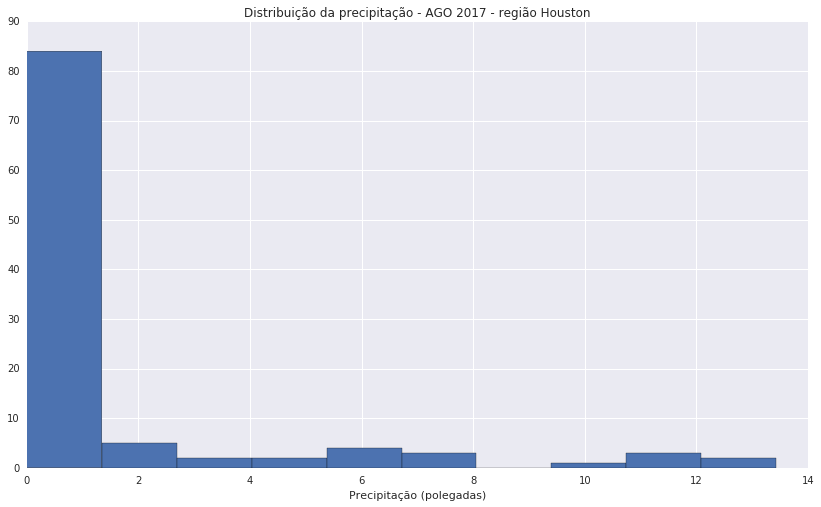

In [18]:
import matplotlib.pyplot as plt  
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 8]  
ago_limpo.d_prcp.hist()  
plt.title(u'Distribuição da precipitação - AGO 2017 - região Houston')  
plt.xlabel(u'Precipitação (polegadas)')  
plt.show()  

<p>Infelizmente, nesta exploração dos dados, vimos que teremos que adotar outra técnica, pois a remoção de instâncias com variáveis com regitros ausentes irá impactar muito a quantidade de registros. </p>

<h2 style="color:blue;">Intervalo Interquartil (IIQ)</h2>

<p>Um critério para verificar chuvas fora do padrão, seria tratar como outliers e usar o IIQ. </p>

<p>
O <b>intervalo interquartil </b> é calculado com base no cálculo de quartis, sendo o primeiro quartil (inferior), o quartil intermediário (mediana), o terceiro quartil (superior), que estão ligados ao conceito de quantil. A diferença entre o quartil superior e o quartil inferior determina a intervalo interquartil.</p>

In [19]:
spread = ago_limpo.describe().T

IQR = spread['75%'] - spread['25%']

# create an outliers column which is either 3 IQRs below the first quartile or
# 3 IQRs above the third quartile
spread['outliers'] = (spread['min']<(spread['25%']-(3*IQR)))|(spread['max'] > (spread['75%']+3*IQR))

spread.ix[spread.outliers,]  

,count,mean,std,min,25%,50%,75%,max,outliers
d_prcp,106.0,1.467925,3.067361,0.0,0.0,0.0,1.1375,13.43,True


<p>Como esperado, a varível precipitação (prcp) apresentou instâncias como outliers, comprovando a existência de chuvas extremas no mês de agosto de 2017.</p> 

<h2 style="color:blue;">Percentil a 99% como critério de precipitação extrema</h2>

<p>Outro critério sugerido na literatura é calcular o percential a 99% considerando o clima da localidade.</p>

<p>De acordo com "Diretrizes sobre a definição e monitoramento de clima extremo e eventos climáticos extremos" proposta pela Organização Meteorológica Mundial, o critério mais adotado para classificar a precipitação extrema, é calcular o percentil da precipitação acumulada a 0,99 em 24 horas.</p>

<p>Vamos verificar em agosto de 2016.</p>

In [20]:
%sql --module j_houston_2016
SELECT d.prcp FROM [bigquery-public-data:noaa_gsod.gsod2016] d
  JOIN [bigquery-public-data:noaa_gsod.stations] ws
  ON d.stn = ws.usaf
    and d.wban = ws.wban
  JOIN (SELECT usaf, wban, CONCAT(STRING(INTEGER(lat + 90 * 1000 /100)), '-' ,  STRING (INTEGER(lon + 180 * 1000 /100))) as bucket 
  FROM  [bigquery-public-data:noaa_gsod.stations] 
 where country = 'US'
    and FLOAT(lat) > -90.0 and FLOAT(lat) < 90.0
    and FLOAT(lon) > -180.0 and FLOAT(lon) < 180.0
    and  CONCAT(STRING(INTEGER(lat + 90 * 1000 /100)), '-' ,  STRING (INTEGER(lon + 180 * 1000 /100))) = '929-1704'
order by bucket) b
    on b.usaf = ws.usaf
   and b.wban = ws.wban
where ws.state is not null
and ws.country = 'US'
and d.prcp < 99.99
and INTEGER(d.mo) = 8

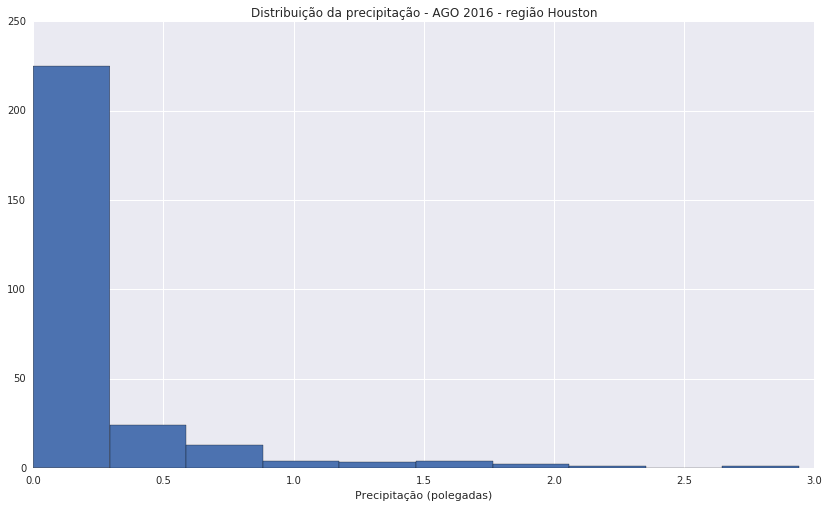

In [21]:
ago_2016 = bq.Query(j_houston_2016).to_dataframe()
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 8]  
ago_2016.d_prcp.hist()  
plt.title(u'Distribuição da precipitação - AGO 2016 - região Houston')  
plt.xlabel(u'Precipitação (polegadas)')  
plt.show()  

In [22]:
import numpy as np
p = np.percentile(ago_2016['d_prcp'], 99) # return 99%th percentile
print p

1.9364


<p>Calculando na estação passada (ano 2016), o percentil foi 1.9364 polegadas, muito próximo da literatura brasileira, 50 mm/24h.</p>

<p>No estado do Rio de janeiro, usando redes neurais pesquisadores obtiveram uma acurácia de 55%, um ganho de 67% comparado com modelo predição ordinário, dados 2000 a 2010, utilizando o liminar de 50 mm/24h (Dolif Neto e Nobre, 2012).</p>

In [23]:
prcp_extreme = ago_limpo[ago_limpo['d_prcp']> 1.9364]
len (prcp_extreme)

21

<p> In Houston houve 21 eventos de precipitação extrema no mês de agosto 2017, considerando o critério percential a 99% em relação ao ano de 2016.</p>

<h2 style="color:blue;">Criando o dataset para treinamento e validação</h2>

<p>Vamos selecionar para treinamento e validação os meses de agosto de 1985 até 2015 desta região.</p>

In [24]:
def create_query(year):
  base_query = """
          SELECT d.stn, d.da, d.mo, d.year, d.temp, d.dewp, d.stp, d.wdsp, d.mxpsd, d.gust, d.prcp, d.rain_drizzle, d.snow_ice_pellets, d.hail, d.thunder, d.tornado_funnel_cloud 
          FROM 
            [bigquery-public-data:noaa_gsod.gsod{0}] d
            JOIN [bigquery-public-data:noaa_gsod.stations] ws
            ON d.stn = ws.usaf
              and d.wban = ws.wban
            JOIN (SELECT usaf, wban, CONCAT(STRING(INTEGER(lat + 90 * 1000 /100)), '-' ,  STRING (INTEGER(lon + 180 * 1000 /100))) as bucket 
            FROM  [bigquery-public-data:noaa_gsod.stations] 
           where country = 'US'
              and FLOAT(lat) > -90.0 and FLOAT(lat) < 90.0
              and FLOAT(lon) > -180.0 and FLOAT(lon) < 180.0
              and  CONCAT(STRING(INTEGER(lat + 90 * 1000 /100)), '-' ,  STRING (INTEGER(lon + 180 * 1000 /100))) = '929-1704'
          order by bucket) b
              on b.usaf = ws.usaf
             and b.wban = ws.wban
          where ws.state is not null
          and ws.country = 'US'
          and INTEGER(d.mo) = 8
          order by d.stn, d.da
    """
  query = base_query.format(year)
  return query

df = pd.DataFrame([])

for y in range(1985,2016):
  r = bq.Query(create_query(y)).to_dataframe()
  df = df.append(r)

<h3 style="color:red;">Verificando a distribuição do conjunto de treinamento e validação</h3>

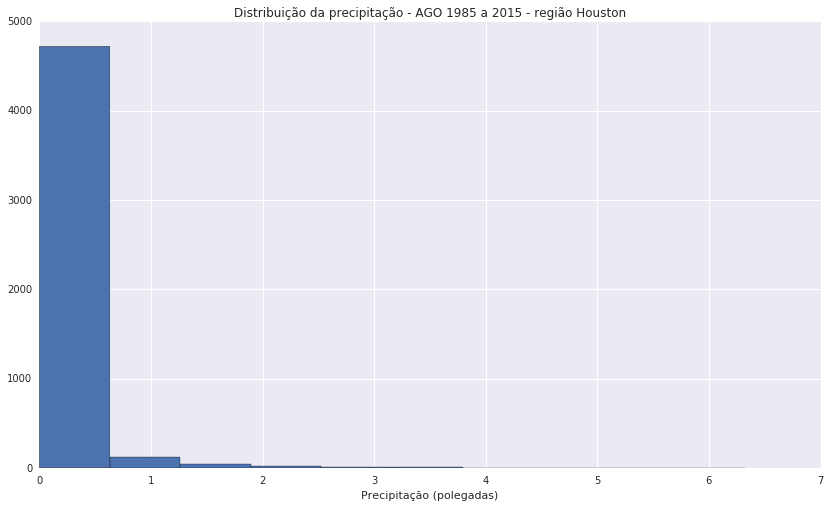

In [25]:
import matplotlib.pyplot as plt  
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 8]  
prcp30_limpo = df[df['d_prcp']< 99.99]
prcp30_limpo.d_prcp.hist()  
plt.title(u'Distribuição da precipitação - AGO 1985 a 2015 - região Houston')  
plt.xlabel(u'Precipitação (polegadas)')  
plt.show()  

<h3 style="color:red;">Limiar para classificar a precipitação como extrema do conjunto de treinamento e validação</h3>

In [26]:
import numpy as np
p = np.percentile(prcp30_limpo['d_prcp'], 99) # return 99%th percentile
print p

1.6548


<p>Considerando os últimos 30 anos o limiar é 1.65 polegadas. Comparando com 2016 é limiar mais baixo, 2016 teve um agosto bem mais chuvoso e com mais eventos extremos que a média dos últimos anos</p>

<h3 style="color:red;">Medindo a quantidade de chuvas extremas no período</h3>

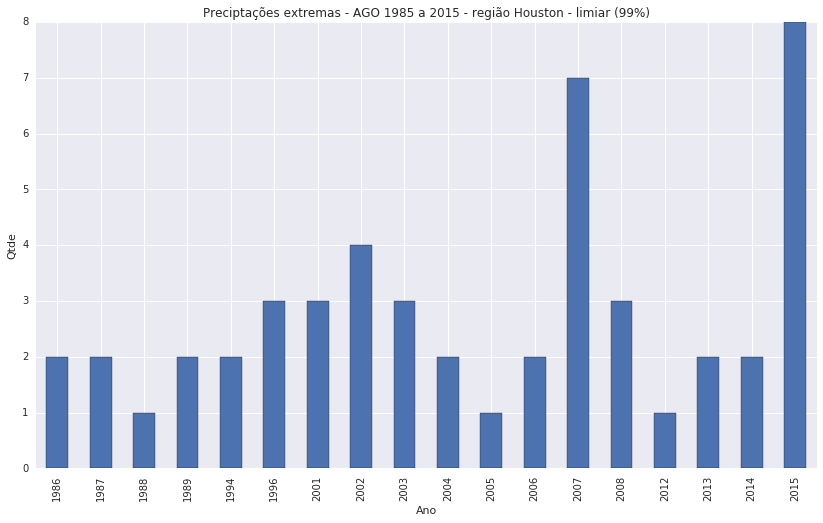

In [27]:
extreme = prcp30_limpo[prcp30_limpo['d_prcp']> 1.6548] 
r = extreme.groupby(['d_year'])['d_prcp'].count()
r.plot.bar()
plt.title(u'Preciptações extremas - AGO 1985 a 2015 - região Houston - limiar (99%)')  
plt.ylabel(u'Qtde')  
plt.xlabel(u'Ano')  
plt.show()

<h2 style="color:blue;">Feature engineering</h2>

<p>O objetivo é realizar a previsão destes eventos usando as variáveis de 3 dias atrás. No estudo de Dolif Neto e Nobre (2012) foram extraídas variavéis também de 3 dias atrás dos fenômenos precipitações extremas. Assim vamos derivar as variáveis de 3 dias atrás antes do fenômeno. Inicialente <b>vamos derivar somente a precipitação</b>, testar e depois fazer para todas as varíaveis</p>

In [28]:
prcp30_limpo = prcp30_limpo.apply(pd.to_numeric, errors='coerce')  

tmp = prcp30_limpo[['d_stn','d_da','d_mo','d_year','d_prcp']]
tmp = tmp.sort_values(['d_year','d_stn','d_da'])
tmp = tmp.reset_index(drop=True)

In [29]:
N = 1 #1 dia antes
feature = 'd_prcp'

nth_prior =[]

# Devirando a variavel para uma lista representando a enesima valor da variavel, se for o primeiro dia não terá dia anterior.
for y in range(1985,2016):
  df_year = tmp[tmp['d_year']== y]
  df_year = df_year.reset_index(drop=True)
  rows = df_year.shape[0]
  prior= [None]*N + [df_year[feature][i-N] for i in range(N, rows)]
  nth_prior = nth_prior + prior
  
col_name = "{}_{}".format(feature, N)  
tmp[col_name] = nth_prior  
tmp[:10]   

,d_stn,d_da,d_mo,d_year,d_prcp,d_prcp_1
0,722430,1,8,1985,0.00,NaN
1,722430,2,8,1985,0.00,0.00
2,722430,3,8,1985,0.22,0.00
3,722430,4,8,1985,0.00,0.22
4,722430,5,8,1985,0.00,0.00
5,722430,6,8,1985,0.00,0.00
6,722430,7,8,1985,0.00,0.00
7,722430,8,8,1985,0.11,0.00
8,722430,9,8,1985,0.01,0.11
9,722430,10,8,1985,0.00,0.01


<p>Veja que para a estação ID 722430 no dia 4/8/1985, a precipitação do dia anterior (d_prcp_1) é exatamente o valor medido no dia 03/08/1985. Agora vamos fazer isto para todas as variaveis.</p>

In [30]:
def derivar_valor_anterior(df, dias, variavel):
  N = dias
  feature = variavel
  tmp = df

  nth_prior =[]

  # Devirando a variavel para uma lista representando a enesima valor da variavel, se for o primeiro dia não terá dia anterior.
  for y in range(1985,2016):
    df_year = tmp[tmp['d_year']== y]
    df_year = df_year.reset_index(drop=True)
    rows = df_year.shape[0]
    prior= [None]*N + [df_year[feature][i-N] for i in range(N, rows)]
    nth_prior = nth_prior + prior

  col_name = "{}_{}".format(feature, N)  
  tmp[col_name] = nth_prior


df_dev = df.apply(pd.to_numeric, errors='coerce')  
df_dev = df_dev.sort_values(['d_year','d_stn','d_da'])
df_dev = df_dev.reset_index(drop=True)
  
for var in list(df_dev):
  if var not in ['d_stn','d_da','d_mo','d_year']:
    for N in range(1, 4):
      derivar_valor_anterior(df_dev,N,var)

df_dev.columns 

Index([                   u'd_stn',                     u'd_da',
                           u'd_mo',                   u'd_year',
                         u'd_temp',                   u'd_dewp',
                          u'd_stp',                   u'd_wdsp',
                        u'd_mxpsd',                   u'd_gust',
                         u'd_prcp',           u'd_rain_drizzle',
             u'd_snow_ice_pellets',                   u'd_hail',
                      u'd_thunder',   u'd_tornado_funnel_cloud',
                       u'd_temp_1',                 u'd_temp_2',
                       u'd_temp_3',                 u'd_dewp_1',
                       u'd_dewp_2',                 u'd_dewp_3',
                        u'd_stp_1',                  u'd_stp_2',
                        u'd_stp_3',                 u'd_wdsp_1',
                       u'd_wdsp_2',                 u'd_wdsp_3',
                      u'd_mxpsd_1',                u'd_mxpsd_2',
                      u'd

<p>Pronto! Agora temos variaveis respectivas de 1, 2, 3 dias atrás. Exemplo: d_prcp_1, d_prcp_2, d_prcp_3 referentes a precipitação 1, 2 e 3 dias atrás respectivamente.</p>

<h2 style="color:blue;">Limpeza dos dados</h2>

<p>Conforme dito anteriormente, existem muitos dados ausentes para algumas variáveis. Podemos excluir as instâncias, mas precisamos ver se perderíamos muitos dados</p>

In [31]:
df_dev = df_dev.apply(pd.to_numeric, errors='coerce')  
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5197 entries, 0 to 5196
Data columns (total 52 columns):
d_stn                       5197 non-null int64
d_da                        5197 non-null int64
d_mo                        5197 non-null int64
d_year                      5197 non-null int64
d_temp                      5197 non-null float64
d_dewp                      5197 non-null float64
d_stp                       5197 non-null float64
d_wdsp                      5197 non-null float64
d_mxpsd                     5197 non-null float64
d_gust                      5197 non-null float64
d_prcp                      5197 non-null float64
d_rain_drizzle              5197 non-null int64
d_snow_ice_pellets          5197 non-null int64
d_hail                      5197 non-null int64
d_thunder                   5197 non-null int64
d_tornado_funnel_cloud      5197 non-null int64
d_temp_1                    5166 non-null float64
d_temp_2                    5135 non-null float64
d_temp_3   

In [32]:
df_dev[:10]

,d_stn,d_da,d_mo,d_year,d_temp,d_dewp,d_stp,d_wdsp,d_mxpsd,d_gust,...,d_snow_ice_pellets_3,d_hail_1,d_hail_2,d_hail_3,d_thunder_1,d_thunder_2,d_thunder_3,d_tornado_funnel_cloud_1,d_tornado_funnel_cloud_2,d_tornado_funnel_cloud_3
0,722430,1,8,1985,84.7,73.2,1012.8,5.4,9.9,999.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,722430,2,8,1985,86.3,73.7,1010.8,5.6,8.9,999.9,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
2,722430,3,8,1985,81.1,72.3,1011.2,4.0,19.0,32.1,...,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN
3,722430,4,8,1985,84.8,75.3,1010.8,5.6,11.1,999.9,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,722430,5,8,1985,84.3,74.5,1011.5,5.5,8.9,999.9,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,722430,6,8,1985,84.6,73.6,1010.8,6.1,13.0,999.9,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,722430,7,8,1985,85.4,73.9,1010.3,6.4,10.1,999.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,722430,8,8,1985,83.0,72.8,1009.9,5.7,12.0,999.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,722430,9,8,1985,85.3,74.4,1010.1,6.6,11.1,999.9,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,722430,10,8,1985,85.0,73.1,1011.2,6.0,10.1,999.9,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [33]:
df_temp = df_dev[(df_dev < 9999.9000).all(axis=1)]
print ('Tamanho antes da limpeza: %s' %str(len(df_dev))) 
print ('Tamanho depois da limpeza: %s' %str(len(df_temp))) 

Tamanho antes da limpeza: 5197
Tamanho depois da limpeza: 0


<p>A conclusão é que todo registro tem algum dado ausente. Assim vamos verificar se tem alguma variável que apresenta maiores problemas.<p/>

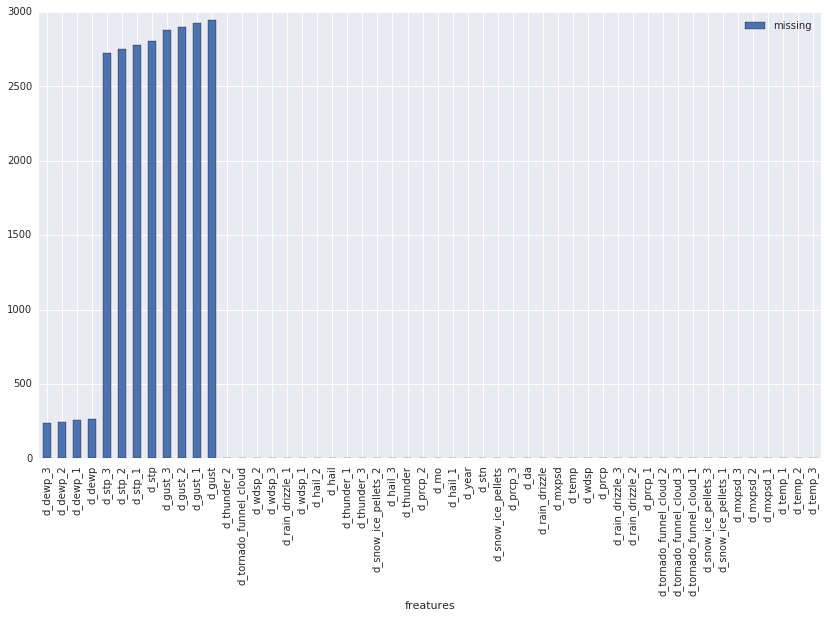

In [34]:
def contabilizar_dados_ausentes(df):
  dn = {}
  
  for v in df.columns:
    df_grp = df[df[v] == 9999.9]
    dn[v] = len(df_grp)

  for v in ['d_gust','d_gust_1', 'd_gust_2', 'd_gust_3']:
    if v in df.columns:
      df_grp = df[df[v] == 999.9]
      dn[v] = dn[v] + len(df_grp)

  for v in ['d_prcp','d_prcp_1', 'd_prcp_2', 'd_prcp_3']:
    if v in df.columns:
      df_grp = df[df[v] == 99.9]
      dn[v] = dn[v] + len(df_grp) 
    
  pdn = pd.DataFrame(dn.items(), columns=['freatures', 'missing'])
  pdn = pdn[pdn > 0]
  pdn = pdn.sort_values(['missing'])
  
  return pdn

pdn = contabilizar_dados_ausentes(df_dev)
pdn.plot.bar(x='freatures', y='missing')
plt.show()

<p> As varíveis velocidade máxima do vento do dia (d_mxpsd), velocidade do fenômeno de aumento repentino do vento (d_gust), média da velocidade do vento (d_wdsp), temperatura do ponto de orvaloho (d_dewp) e pressão atmosferica (d_stp) apresentam valores nulos significativos. Sendo a variável d_gust a mais problemática.</p>

<p>A decisão será remover velocidade do fenômeno de aumento repentino do vento (d_gust) e  pressão atmosferica (d_stp). E interpolar as demais utilizando algum método.</p>

In [35]:
df_limpo = df_dev.copy(deep=True)

for column in df_limpo.columns:
    if column in ['d_gust','d_gust_1','d_gust_2','d_gust_3']:
        df_limpo = df_limpo.drop(column, axis = 1)
        
for column in df_limpo.columns:
    if column in ['d_stp','d_stp_1','d_stp_2','d_stp_3']:
        df_limpo = df_limpo.drop(column, axis = 1)

df_limpo.columns

Index([                   u'd_stn',                     u'd_da',
                           u'd_mo',                   u'd_year',
                         u'd_temp',                   u'd_dewp',
                         u'd_wdsp',                  u'd_mxpsd',
                         u'd_prcp',           u'd_rain_drizzle',
             u'd_snow_ice_pellets',                   u'd_hail',
                      u'd_thunder',   u'd_tornado_funnel_cloud',
                       u'd_temp_1',                 u'd_temp_2',
                       u'd_temp_3',                 u'd_dewp_1',
                       u'd_dewp_2',                 u'd_dewp_3',
                       u'd_wdsp_1',                 u'd_wdsp_2',
                       u'd_wdsp_3',                u'd_mxpsd_1',
                      u'd_mxpsd_2',                u'd_mxpsd_3',
                       u'd_prcp_1',                 u'd_prcp_2',
                       u'd_prcp_3',         u'd_rain_drizzle_1',
               u'd_rain_d

<p>Agora temos outras varíaveis para tratar, que ainda estão afetando muitas instâncias</p>

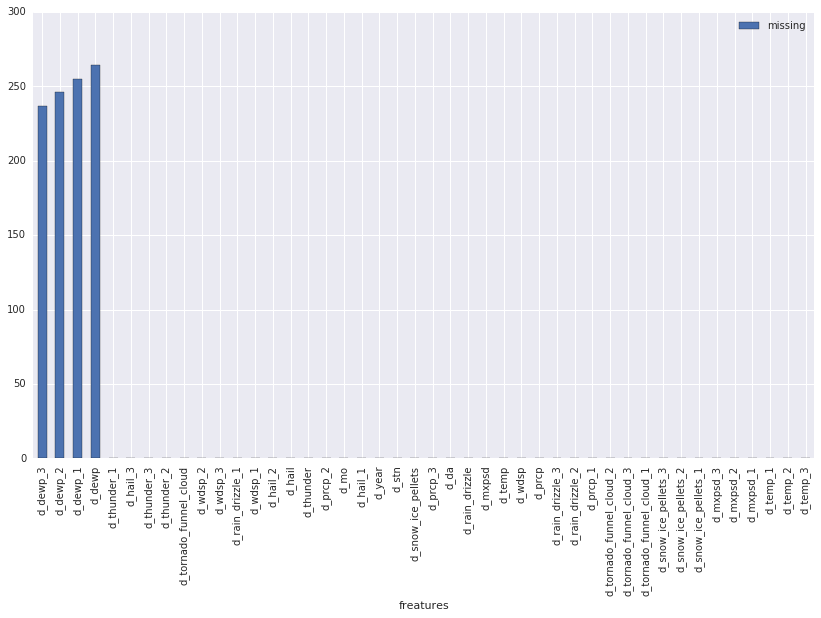

In [36]:
p = contabilizar_dados_ausentes(df_limpo)
p.plot.bar(x='freatures', y='missing')
plt.show()

<p>Primeiramente vamos marcar os dados ausentes.</p>

In [37]:
def marcar_dados_ausentes(df):
  for v in df.columns:
    df[v] = df[v].replace([9999.9],"NaN")

marcar_dados_ausentes(df_limpo)

for v in df_limpo.columns:
  if v in ['d_prcp','d_prcp_1', 'd_prcp_2', 'd_prcp_3']:
    df_limpo[v] = df_limpo[v].replace([99.9],"NaN")

df_limpo = df_limpo.apply(pd.to_numeric, errors='coerce')  
df_limpo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5197 entries, 0 to 5196
Data columns (total 44 columns):
d_stn                       5197 non-null int64
d_da                        5197 non-null int64
d_mo                        5197 non-null int64
d_year                      5197 non-null int64
d_temp                      5197 non-null float64
d_dewp                      4933 non-null float64
d_wdsp                      5197 non-null float64
d_mxpsd                     5197 non-null float64
d_prcp                      5197 non-null float64
d_rain_drizzle              5197 non-null int64
d_snow_ice_pellets          5197 non-null int64
d_hail                      5197 non-null int64
d_thunder                   5197 non-null int64
d_tornado_funnel_cloud      5197 non-null int64
d_temp_1                    5166 non-null float64
d_temp_2                    5135 non-null float64
d_temp_3                    5104 non-null float64
d_dewp_1                    4911 non-null float64
d_dewp_2   

<p>Interpolá-los</p>

<h2 style="color:blue;">Interpolandos dados para outras variáveis: dados ausentes</h2>

In [38]:
df_intptd = df_limpo.copy(deep=True)
for v in df_intptd:
  if v not in ['d_stn','d_da','d_mo','d_year']:
    df_intptd[v] = df_intptd[v].astype(float)

df_intptd = df_intptd.interpolate(method='linear', axis=0).ffill().bfill()
df_intptd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5197 entries, 0 to 5196
Data columns (total 44 columns):
d_stn                       5197 non-null int64
d_da                        5197 non-null int64
d_mo                        5197 non-null int64
d_year                      5197 non-null int64
d_temp                      5197 non-null float64
d_dewp                      5197 non-null float64
d_wdsp                      5197 non-null float64
d_mxpsd                     5197 non-null float64
d_prcp                      5197 non-null float64
d_rain_drizzle              5197 non-null float64
d_snow_ice_pellets          5197 non-null float64
d_hail                      5197 non-null float64
d_thunder                   5197 non-null float64
d_tornado_funnel_cloud      5197 non-null float64
d_temp_1                    5197 non-null float64
d_temp_2                    5197 non-null float64
d_temp_3                    5197 non-null float64
d_dewp_1                    5197 non-null float64
d

In [39]:
df_intptd[:10]

,d_stn,d_da,d_mo,d_year,d_temp,d_dewp,d_wdsp,d_mxpsd,d_prcp,d_rain_drizzle,...,d_snow_ice_pellets_3,d_hail_1,d_hail_2,d_hail_3,d_thunder_1,d_thunder_2,d_thunder_3,d_tornado_funnel_cloud_1,d_tornado_funnel_cloud_2,d_tornado_funnel_cloud_3
0,722430,1,8,1985,84.7,73.2,5.4,9.9,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,722430,2,8,1985,86.3,73.7,5.6,8.9,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,722430,3,8,1985,81.1,72.3,4.0,19.0,0.22,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,722430,4,8,1985,84.8,75.3,5.6,11.1,0.00,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,722430,5,8,1985,84.3,74.5,5.5,8.9,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,722430,6,8,1985,84.6,73.6,6.1,13.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,722430,7,8,1985,85.4,73.9,6.4,10.1,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,722430,8,8,1985,83.0,72.8,5.7,12.0,0.11,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,722430,9,8,1985,85.3,74.4,6.6,11.1,0.01,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,722430,10,8,1985,85.0,73.1,6.0,10.1,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


<p>Adicionando um flag para indicar se a chuva é extrema ou não</p>

<h2 style="color:blue;">Adicionando o flag para indicar se a chuva é extrema ou não</h2>

In [40]:
df_intptd['heavy'] = (df_intptd['d_prcp'] > 1.6548)
df_intptd['heavy']  = df_intptd['heavy'].astype(object).replace({False: 0, True: 1})
df_intptd[:10]

,d_stn,d_da,d_mo,d_year,d_temp,d_dewp,d_wdsp,d_mxpsd,d_prcp,d_rain_drizzle,...,d_hail_1,d_hail_2,d_hail_3,d_thunder_1,d_thunder_2,d_thunder_3,d_tornado_funnel_cloud_1,d_tornado_funnel_cloud_2,d_tornado_funnel_cloud_3,heavy
0,722430,1,8,1985,84.7,73.2,5.4,9.9,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,722430,2,8,1985,86.3,73.7,5.6,8.9,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,722430,3,8,1985,81.1,72.3,4.0,19.0,0.22,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,722430,4,8,1985,84.8,75.3,5.6,11.1,0.00,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,722430,5,8,1985,84.3,74.5,5.5,8.9,0.00,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
5,722430,6,8,1985,84.6,73.6,6.1,13.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
6,722430,7,8,1985,85.4,73.9,6.4,10.1,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,722430,8,8,1985,83.0,72.8,5.7,12.0,0.11,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,722430,9,8,1985,85.3,74.4,6.6,11.1,0.01,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
9,722430,10,8,1985,85.0,73.1,6.0,10.1,0.00,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


<h2 style="color:blue;">Pearson correlation coefficient</h2>

In [41]:
df_corl = df_intptd.copy(deep=True)
for v in df_corl.columns:
  if v in ['d_stn','d_da','d_mo','d_year']:
    df_corl = df_corl.drop(v, axis = 1)

df_corl.corr()[['d_prcp']].sort_values('d_prcp')  

,d_prcp
d_temp,-0.090553
d_mxpsd,-0.040732
d_mxpsd_1,-0.031311
d_mxpsd_2,-0.031242
d_mxpsd_3,-0.025583
d_wdsp,-0.025145
d_wdsp_1,-0.024805
d_thunder_3,-0.020581
d_wdsp_2,-0.016196
d_temp_1,-0.013607


<p>Nenhuma variável apresentou uma correlação alta. Assim vamos aplicar um modelo não linear.</p>

<h2 style="color:blue;">Treinamento e validação</h2>

<p>Colocando a variável alvo na primeira posição do dataframe</p>

In [42]:
TARGET = u'd_temp'
#TARGET = u'heavy'

cols = list(df_intptd)
cols.insert(0, cols.pop(cols.index(TARGET)))
df_intptd = df_intptd.ix[:, cols]

In [43]:
for v in df_intptd.columns:
  if v in ['d_stn','d_da','d_mo','d_year']:
    df_intptd = df_intptd.drop(v, axis = 1)

FEATURES = df_intptd.columns.tolist()
FEATURES.remove(TARGET)

TRAIN_SIZE = int(0.7*len(df_intptd))
df_train = df_intptd[:TRAIN_SIZE]
df_valid = df_intptd[TRAIN_SIZE:]

In [44]:
import tensorflow as tf
import shutil

print tf.__version__

1.2.1


<h3 style="color:red;">Funções para ler o dataframe para inserir no tf.constant</h3>

In [45]:
def make_input_fn(df):
  def pandas_to_tf(pdcol):
    # convert the pandas column values to float
    t = tf.constant(pdcol.astype('float32').values)
    # take the column which is of shape (N) and make it (N, 1)
    return tf.expand_dims(t, -1)
  
  def input_fn():
    # create features, columns
    features = {k: pandas_to_tf(df[k]) for k in FEATURES}
    labels = tf.constant(df[TARGET].values)
    return features, labels
  return input_fn
  
def make_feature_cols():
  input_columns = [tf.contrib.layers.real_valued_column(k) for k in FEATURES]
  return input_columns

<h3 style="color:green;">Regressão Linear</h3>

In [46]:
tf.logging.set_verbosity(tf.logging.ERROR)
shutil.rmtree('prcp', ignore_errors=True) # start fresh each time
model = tf.contrib.learn.LinearRegressor(feature_columns=make_feature_cols(), model_dir='prcp')
model.fit(input_fn=make_input_fn(df_train), steps=10);

In [47]:
def print_rmse(model, name, input_fn):
  metrics = model.evaluate(input_fn=input_fn, steps=1)
  print u'RMSE(Root Mean Squared Error) no {} = {}'.format(name, np.sqrt(metrics['loss']))
  
print_rmse(model, u'conjunto de validação', make_input_fn(df_valid))

RMSE(Root Mean Squared Error) no conjunto de validação = 3.52427482605


In [48]:
model = tf.contrib.learn.LinearRegressor(feature_columns=make_feature_cols(), model_dir='prcp')
preds = model.predict(input_fn=make_input_fn(df_valid))
m = list(preds)

<p>Comparando as predições com o conjunto de validação.</p>

In [49]:
df_comparar = df_valid.copy(deep=True)
df_comparar = df_comparar.reset_index(drop=True)

df_comparar['resultado'] = m

cols = list(df_comparar)
cols.insert(0, cols.pop(cols.index('resultado')))
df_comparar = df_comparar.ix[:, cols]

print df_comparar[:10]

   resultado  d_temp  d_dewp  d_wdsp  d_mxpsd  d_prcp  d_rain_drizzle  \
0  84.568108    86.5    73.9     6.1     12.0    0.00             0.0   
1  84.672096    85.9    73.3     6.6     14.0    0.00             1.0   
2  84.642212    85.2    72.3     3.1     20.0    0.00             1.0   
3  83.826820    84.7    70.0     5.1     15.0    0.19             0.0   
4  82.106346    85.5    64.1     7.5     14.0    0.00             0.0   
5  80.038719    84.8    61.9     5.9     12.0    0.00             0.0   
6  78.878571    84.3    67.2     4.8     11.1    0.00             0.0   
7  79.640587    85.0    74.6     3.8     13.0    0.00             1.0   
8  81.649292    83.0    76.0     3.4     18.1    0.02             1.0   
9  83.733917    82.2    75.7     3.4      8.9    0.95             1.0   

   d_snow_ice_pellets  d_hail  d_thunder  ...    d_hail_1  d_hail_2  d_hail_3  \
0                 0.0     0.0        0.0  ...         0.0       0.0       0.0   
1                 0.0     0.0     


<p><b>Root Mean Square Error (RMSE)</b> is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. Root mean square error is commonly used in climatology, forecasting, and regression analysis to verify experimental results.</P>

<h3 style="color:green;"> Deep Neural Network regression </h3>

In [50]:
shutil.rmtree('prcp', ignore_errors=True)
model = tf.contrib.learn.DNNRegressor(hidden_units=[32, 8, 2], feature_columns=make_feature_cols(), 
                                      optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=0.3,l1_regularization_strength=0.001),
                                      model_dir='prcp', )
model.fit(input_fn=make_input_fn(df_train), steps=500);
print_rmse(model, u'conjunto de validação', make_input_fn(df_valid))
preds = model.predict(input_fn=make_input_fn(df_valid))
m = list(preds)

RMSE(Root Mean Squared Error) no conjunto de validação = 8.08702850342


In [51]:
df_comparar = df_valid.copy(deep=True)
df_comparar = df_comparar.reset_index(drop=True)

df_comparar['resultado'] = m

cols = list(df_comparar)
cols.insert(0, cols.pop(cols.index('resultado')))
df_comparar = df_comparar.ix[:, cols]

print df_comparar[:10]

   resultado  d_temp  d_dewp  d_wdsp  d_mxpsd  d_prcp  d_rain_drizzle  \
0  86.036911    86.5    73.9     6.1     12.0    0.00             0.0   
1  85.597122    85.9    73.3     6.6     14.0    0.00             1.0   
2  83.132156    85.2    72.3     3.1     20.0    0.00             1.0   
3  84.695702    84.7    70.0     5.1     15.0    0.19             0.0   
4  81.761002    85.5    64.1     7.5     14.0    0.00             0.0   
5  82.970764    84.8    61.9     5.9     12.0    0.00             0.0   
6  82.754623    84.3    67.2     4.8     11.1    0.00             0.0   
7  80.684860    85.0    74.6     3.8     13.0    0.00             1.0   
8  78.470963    83.0    76.0     3.4     18.1    0.02             1.0   
9  82.265778    82.2    75.7     3.4      8.9    0.95             1.0   

   d_snow_ice_pellets  d_hail  d_thunder  ...    d_hail_1  d_hail_2  d_hail_3  \
0                 0.0     0.0        0.0  ...         0.0       0.0       0.0   
1                 0.0     0.0     

<h2 style="color:blue;">Conclusão</h2>

<p>Os resultados não foram bons, visto que são viciados, mas a proposta é rodar novamente mas desta vez aplicando validação cruzada. E refazer o holdout mas feito corretamente, ou seja, selecionar randomicamente. Aplicando o modelo regressão linear o <b>RMSE(Root Mean Squared Error) foi 22.68 </b> e aplicando redes neurais <b>(DNN Regressor) foi 24.66 </b>.</p>

<p>Os próximos passos são fazer o balanciamento, e possivelmente discretizar a chuva extrema em intervalos ao inves de prever a precipitação em valores contínuos. E selecionar as instâncias de forma randômica.</p>

